In [81]:
import pandas as pd
import numpy as np
import os
import random

import torch
import torch.nn as nn
import os
import itertools
import json
import traceback

from datetime import datetime
from tqdm import tqdm
from pathlib import Path
from dotenv import load_dotenv
from torch.utils.data import DataLoader, TensorDataset

from trajectory_predictor import TrajectoryPredictor, trajectory_loss, DEVICE

BASE = "../../data/aisdk/processed"

# 0 - Fetch the data

In [82]:
train_traj = np.load(os.path.join(BASE, "windows/train_trajectories.npz"))
val_traj = np.load(os.path.join(BASE, "windows/val_trajectories.npz"))
test_traj = np.load(os.path.join(BASE, "windows/test_trajectories.npz"))

X_train, X_val = train_traj["past"], val_traj["past"]
y_train, y_val = train_traj["future"], val_traj["future"]
c_train, c_val = train_traj["cluster"], val_traj["cluster"]

In [83]:
# %% Create data loaders
def make_loaders(batch_size, cid, min_samples=10):
    """
    Build train/val dataloaders for a single cluster `cid`.
    Returns (train_loader, val_loader). Raises if not enough data for a given cluster.
    """

    # Boolean masks for this cluster
    train_mask = (c_train == cid)
    val_mask   = (c_val == cid)

    # Subset numpy arrays
    X_tr = X_train[train_mask]
    y_tr = y_train[train_mask]
    X_v  = X_val[val_mask]
    y_v  = y_val[val_mask]

    n_tr, n_v = X_tr.shape[0], X_v.shape[0]
    print(f"\n[Cluster {cid}] Num train windows: {n_tr}, Num val windows: {n_v}")
    
    if n_tr < min_samples or n_v < min_samples:
        raise RuntimeError(
            f"Not enough samples for cluster {cid}: "
            f"{n_tr} train, {n_v} val (min {min_samples})."
        )

    # %% Convert to PyTorch tensors
    X_train_t = torch.tensor(X_tr, dtype=torch.float32)
    X_val_t   = torch.tensor(X_v,   dtype=torch.float32)

    y_train_t = torch.tensor(y_tr, dtype=torch.float32)
    y_val_t   = torch.tensor(y_v,   dtype=torch.float32)

    # Create data loaders
    print(f"[Cluster {cid}] Tensor shapes:")
    print(f"  X_train_t: {X_train_t.shape}")
    print(f"  X_val_t:   {X_val_t.shape}")
    print(f"  y_train_t: {y_train_t.shape}")
    print(f"  y_val_t:   {y_val_t.shape}")

    train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=batch_size, shuffle=True, drop_last=False)
    val_loader = DataLoader(TensorDataset(X_val_t, y_val_t), batch_size=batch_size, shuffle=False)
    
    return train_loader, val_loader


# 1 - Define training functions 
## 1.1 - One run

In [ ]:
def _train_one_run(cfg, train_loader, val_loader, cid):
    """
    Train a TrajectoryPredictor for one hyperparameter configuration.

    Returns:
      model,
      train_mses, val_mses,
      train_rmses, val_rmses,
      best_val_mse, best_epoch
    """

    device = cfg["device"]

    model = TrajectoryPredictor(
        input_dim=cfg["input_dim"],
        hidden_dim=cfg["hidden_dim"],
        output_dim=cfg["output_dim"],
        num_layers_encoder=cfg["num_layers_encoder"],
        num_layers_decoder=cfg["num_layers_decoder"],
        attn_dim=cfg["attn_dim"]
    ).to(device)

    opt = torch.optim.Adam(model.parameters(), lr=cfg["lr"], weight_decay=cfg["weight_decay"])

    best_val_mse = float("inf")
    best_epoch = -1

    train_mses = []
    val_mses   = []
    train_rmses = []
    val_rmses   = []

    # ------ Training loop ------ 
    for epoch in range(1, cfg["epochs"] + 1):

        model.train()
        train_total = 0.0
        train_samples = 0

        for xb, yb in tqdm(train_loader, desc=f"Cluster {cid} Epoch {epoch}/{cfg['epochs']}"):
            xb = xb.to(device)
            yb = yb.to(device)


            opt.zero_grad()
            yb_pred = model(xb, target_length=yb.size(1), targets=yb, teacher_forcing_ratio=cfg["teacher_forcing"])
            
            loss = trajectory_loss(yb_pred, yb)
            loss.backward()
            
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=cfg["max_norm"])
            opt.step()
            train_total += loss.item() * xb.size(0)
            train_samples += xb.size(0)


        train_mse = train_total / max(train_samples, 1)
        train_rmse = float(np.sqrt(train_mse))


        # --- VALIDATION ---
        model.eval()
        val_total = 0.0
        val_samples = 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb = xb.to(device)
                yb = yb.to(device)

                yb_pred = model(
                    xb,
                    target_length=yb.size(1),
                    targets=None,
                    teacher_forcing_ratio=0.0
                )

                loss = trajectory_loss(yb_pred, yb)
                

                val_total += loss.item() * xb.size(0)
                val_samples += xb.size(0)

        val_mse = val_total / max(val_samples, 1)
        val_rmse = float(np.sqrt(val_mse))

        train_mses.append(train_mse)
        val_mses.append(val_mse)
        train_rmses.append(train_rmse)
        val_rmses.append(val_rmse)

        print(
            f"[Cluster {cid}] Epoch {epoch}/{cfg['epochs']} "
            f"| Train MSE: {train_mse:.6f} (RMSE: {train_rmse:.6f}) "
            f"| Val MSE: {val_mse:.6f} (RMSE: {val_rmse:.6f})"
        )

        if val_mse < best_val_mse:
            best_val_mse = val_mse
            best_epoch = epoch
            print(
                f"  → New best Val MSE for cluster {cid}: {best_val_mse:.6f} "
                f"(RMSE: {val_rmse:.6f}, epoch {epoch})"
            )

    return model, train_mses, val_mses, train_rmses, val_rmses, best_val_mse, best_epoch,
    


## 1.2 - Function for hyperparameter tuning

In [85]:
# Define key metrics
input_dim = X_train.shape[-1]
device = "cuda" if torch.cuda.is_available() else "cpu"

In [86]:
def hyperparameter_search_trajectory(
    device=device,
    input_dim=input_dim,
    output_dim=input_dim,
    cid=3,
    search_type='grid',
    save_dir='../../checkpoints/hyperparameter_results_trajectory',
):
    os.makedirs(save_dir, exist_ok=True)

    print("=" * 70)
    print(f"HYPERPARAMETER TUNING FOR TRAJECTORY PREDICTOR (Cluster {cid})")
    print("=" * 70)

    # -------- 1) Define search space --------
    if search_type == 'grid':
        param_grid = {
            "hidden_dim": [32, 64],
            "num_layers_encoder": [1],
            "num_layers_decoder": [1],
            "attn_dim": [32],
            "batch_size": [128],

            "lr": [3e-4, 1e-3],
            "weight_decay": [0.0, 1e-4],
            "teacher_forcing": [0.7], #0.7 for stability unless predictions drift badly — then increase to 1.0.
            "max_norm": [1.0],
            "epochs": [20],
        }
        # 2 * 1 * 1 * 1 * 1 * 2 * 2 * 1 * 1 * 1 = 8 configs

    elif search_type == 'quick':
            param_grid = {
        "hidden_dim": [64, 128],
        "num_layers_encoder": [1],     
        "num_layers_decoder": [1],     
        "attn_dim": [64],              
        "batch_size": [128],          
        "lr": [3e-4, 1e-3],
        "weight_decay": [0.0, 1e-4],
        "teacher_forcing": [0.7],
        "max_norm": [1.0],
        "epochs": [15],
        }
        

    else:
        raise ValueError(f"Unknown search_type: {search_type}")

    keys = list(param_grid.keys())
    values = list(param_grid.values())
    combinations = list(itertools.product(*values))
    param_combinations = [dict(zip(keys, combo)) for combo in combinations]

    print(f"{search_type.capitalize()} Search: {len(param_combinations)} combinations")
    print(f"Estimated time: {len(param_combinations) * 5} minutes (VERY rough)")
    print("=" * 70)

    results = []
    best_score = float("inf")  # here: best_val_mse
    best_params = None

    start_time = datetime.now()

    # -------- 2) Main loop over configs --------
    for idx, params in enumerate(param_combinations):
        print("\n" + "=" * 70)
        print(f"Trial {idx + 1}/{len(param_combinations)}  (Cluster {cid})")
        elapsed_min = (datetime.now() - start_time).total_seconds() / 60
        print(f"Time elapsed: {elapsed_min:.1f} min")
        print("=" * 70)

        print("Testing configuration:")
        print(f"  hidden_dim        = {params['hidden_dim']}")
        print(f"  num_layers_enc    = {params['num_layers_encoder']}")
        print(f"  num_layers_dec    = {params['num_layers_decoder']}")
        print(f"  attn_dim          = {params['attn_dim']}")
        print(f"  batch_size        = {params['batch_size']}")
        print(f"  lr                = {params['lr']}")
        print(f"  weight_decay      = {params['weight_decay']}")
        print(f"  teacher_forcing   = {params['teacher_forcing']}")
        print(f"  max_norm          = {params['max_norm']}")
        print(f"  epochs            = {params['epochs']}")
        print()

        try:
            # ---- Build cfg for this run ----
            cfg = {
                "device": device,
                "input_dim": input_dim,
                "output_dim": output_dim,
                "hidden_dim": params["hidden_dim"],
                "num_layers_encoder": params["num_layers_encoder"],
                "num_layers_decoder": params["num_layers_decoder"],
                "attn_dim": params["attn_dim"],
                "batch_size": params["batch_size"],
                "lr": params["lr"],
                "weight_decay": params["weight_decay"],
                "teacher_forcing": params["teacher_forcing"],
                "max_norm": params["max_norm"],
                "epochs": params["epochs"],
            }

            # ---- Train once with this config ----
            train_loader, val_loader = make_loaders(cfg["batch_size"], cid)
            model, train_mses, val_mses, train_rmses, val_rmses, best_val_mse, best_epoch = _train_one_run(cfg, train_loader, val_loader, cid)

            score = float(best_val_mse)

            final_train_mse = float(train_mses[best_epoch - 1])
            final_train_rmse = float(train_rmses[best_epoch - 1])
            best_val_rmse = float(val_rmses[best_epoch - 1])
            overfit_ratio = best_val_mse / max(final_train_mse, 1e-8)


            result = {
                **params,
                "best_val_mse": best_val_mse,
                "best_val_rmse": best_val_rmse,
                "best_epoch": best_epoch,
                "final_train_mse": final_train_mse,
                "final_train_rmse": final_train_rmse,
                "overfit_ratio": overfit_ratio,
                "score": score,  # for sorting
                "trial": idx + 1,
            }

            results.append(result)

            print("Results:")
            print(f"  Best Val MSE : {best_val_mse:.6f} (RMSE: {best_val_rmse:.6f}, epoch {best_epoch})")
            print(f"  Train MSE @best: {final_train_mse:.6f} (RMSE: {final_train_rmse:.6f})")
            print(f"  Overfit ratio : {overfit_ratio:.3f}")
            print(f"  Score (Val MSE): {score:.6f}")

            if score < best_score:
                best_score = score
                best_params = params.copy()
                print("  ⭐ NEW BEST CONFIG FOUND!")
                
                torch.save(model.state_dict(), os.path.join(save_dir, "best_model.pth"))

            # Optionally clear cache if GPU:
            if torch.cuda.is_available():
                torch.cuda.empty_cache()

        except Exception as e:
            print(f"  ❌ FAILED: {str(e)}")
            traceback.print_exc()
            result = {**params, "error": str(e), "trial": idx + 1}
            results.append(result)

    # -------- 3) Save & summarize --------
    if len(results) == 0:
        print("\n❌ No trials completed!")
        return None, None

    df = pd.DataFrame(results)

    if "score" in df.columns:
        df = df.sort_values("score", na_position="last")

    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    csv_path = os.path.join(save_dir, f"results_cluster{cid}_{timestamp}.csv")
    df.to_csv(csv_path, index=False)

    if best_params is None:
        print("\n❌ All trials failed! Check error messages above.")
        return df, None

    json_path = os.path.join(save_dir, f"best_params_cluster{cid}_{timestamp}.json")
    with open(json_path, "w") as f:
        json.dump(best_params, f, indent=2)

    total_time = (datetime.now() - start_time).total_seconds() / 60
    print("\n" + "=" * 70)
    print(f"HYPERPARAMETER SEARCH COMPLETE (Cluster {cid})")
    print("=" * 70)
    print(f"Total time: {total_time:.1f} minutes")
    successful = [r for r in results if "error" not in r]
    print(f"Successful trials: {len(successful)}/{len(results)}")

    print(f"\nBest parameters (score={best_score:.6f}):")
    for k, v in best_params.items():
        print(f"  {k}: {v}")

    print(f"\nResults saved to: {csv_path}")
    print(f"Best params saved to: {json_path}")

    # Top 5 successful configs
    successful_df = df[df["score"].notna()]
    
    top_cols = [
    "hidden_dim",
    "num_layers_encoder",
    "num_layers_decoder",
    "attn_dim",
    "lr",
    "teacher_forcing",
    "weight_decay",
    "best_val_mse",
    "best_val_rmse",
    "final_train_mse",
    "final_train_rmse",
    "overfit_ratio",
    "score",
    ]   
    print("\nTop 5 configurations:")
    print(successful_df[top_cols].head())

    return df, best_params


# 2 - Fetch the data

In [87]:
import itertools
device = "cuda" if torch.cuda.is_available() else "cpu"

input_dim = 5          # e.g. [UTM_x, UTM_y, SOG, v_east, v_north]
output_dim = 5         # same features for future sequence

# Choose which cluster to train
cid = 3

# Train cluster 3 for example
df_traj, best_params_traj = hyperparameter_search_trajectory(
    device=device,
    input_dim=input_dim,
    output_dim=output_dim,
    cid=cid,
    search_type="quick",   # or "grid"
)


HYPERPARAMETER TUNING FOR TRAJECTORY PREDICTOR (Cluster 3)
Quick Search: 8 combinations
Estimated time: 40 minutes (VERY rough)

Trial 1/8  (Cluster 3)
Time elapsed: 0.0 min
Testing configuration:
  hidden_dim        = 64
  num_layers_enc    = 1
  num_layers_dec    = 1
  attn_dim          = 64
  batch_size        = 128
  lr                = 0.0003
  weight_decay      = 0.0
  teacher_forcing   = 0.7
  max_norm          = 1.0
  epochs            = 15


[Cluster 3] Num train windows: 1702, Num val windows: 1702
[Cluster 3] Tensor shapes:
  X_train_t: torch.Size([1702, 30, 5])
  X_val_t:   torch.Size([1702, 30, 5])
  y_train_t: torch.Size([1702, 30, 5])
  y_val_t:   torch.Size([1702, 30, 5])


Cluster 3 Epoch 1/15: 100%|██████████| 14/14 [00:04<00:00,  3.43it/s]


[Cluster 3] Epoch 1/15 | Train MSE: 0.629999 (RMSE: 0.793725) | Val MSE: 0.462324 (RMSE: 0.679944)
  → New best Val MSE for cluster 3: 0.462324 (RMSE: 0.679944, epoch 1)


Cluster 3 Epoch 2/15: 100%|██████████| 14/14 [00:03<00:00,  3.57it/s]


[Cluster 3] Epoch 2/15 | Train MSE: 0.340589 (RMSE: 0.583600) | Val MSE: 0.212769 (RMSE: 0.461269)
  → New best Val MSE for cluster 3: 0.212769 (RMSE: 0.461269, epoch 2)


Cluster 3 Epoch 3/15: 100%|██████████| 14/14 [00:03<00:00,  3.78it/s]


[Cluster 3] Epoch 3/15 | Train MSE: 0.121440 (RMSE: 0.348483) | Val MSE: 0.057458 (RMSE: 0.239703)
  → New best Val MSE for cluster 3: 0.057458 (RMSE: 0.239703, epoch 3)


Cluster 3 Epoch 4/15: 100%|██████████| 14/14 [00:03<00:00,  3.67it/s]


[Cluster 3] Epoch 4/15 | Train MSE: 0.042903 (RMSE: 0.207130) | Val MSE: 0.044464 (RMSE: 0.210865)
  → New best Val MSE for cluster 3: 0.044464 (RMSE: 0.210865, epoch 4)


Cluster 3 Epoch 5/15: 100%|██████████| 14/14 [00:04<00:00,  3.49it/s]


[Cluster 3] Epoch 5/15 | Train MSE: 0.037745 (RMSE: 0.194280) | Val MSE: 0.034528 (RMSE: 0.185818)
  → New best Val MSE for cluster 3: 0.034528 (RMSE: 0.185818, epoch 5)


Cluster 3 Epoch 6/15: 100%|██████████| 14/14 [00:03<00:00,  4.03it/s]


[Cluster 3] Epoch 6/15 | Train MSE: 0.030868 (RMSE: 0.175694) | Val MSE: 0.031365 (RMSE: 0.177102)
  → New best Val MSE for cluster 3: 0.031365 (RMSE: 0.177102, epoch 6)


Cluster 3 Epoch 7/15: 100%|██████████| 14/14 [00:03<00:00,  3.62it/s]


[Cluster 3] Epoch 7/15 | Train MSE: 0.028047 (RMSE: 0.167472) | Val MSE: 0.028391 (RMSE: 0.168497)
  → New best Val MSE for cluster 3: 0.028391 (RMSE: 0.168497, epoch 7)


Cluster 3 Epoch 8/15: 100%|██████████| 14/14 [00:03<00:00,  3.59it/s]


[Cluster 3] Epoch 8/15 | Train MSE: 0.025742 (RMSE: 0.160445) | Val MSE: 0.026413 (RMSE: 0.162521)
  → New best Val MSE for cluster 3: 0.026413 (RMSE: 0.162521, epoch 8)


Cluster 3 Epoch 9/15: 100%|██████████| 14/14 [00:03<00:00,  3.84it/s]


[Cluster 3] Epoch 9/15 | Train MSE: 0.023993 (RMSE: 0.154898) | Val MSE: 0.024899 (RMSE: 0.157795)
  → New best Val MSE for cluster 3: 0.024899 (RMSE: 0.157795, epoch 9)


Cluster 3 Epoch 10/15: 100%|██████████| 14/14 [00:04<00:00,  3.48it/s]


[Cluster 3] Epoch 10/15 | Train MSE: 0.022655 (RMSE: 0.150516) | Val MSE: 0.023685 (RMSE: 0.153899)
  → New best Val MSE for cluster 3: 0.023685 (RMSE: 0.153899, epoch 10)


Cluster 3 Epoch 11/15: 100%|██████████| 14/14 [00:03<00:00,  3.54it/s]


[Cluster 3] Epoch 11/15 | Train MSE: 0.021370 (RMSE: 0.146184) | Val MSE: 0.022673 (RMSE: 0.150575)
  → New best Val MSE for cluster 3: 0.022673 (RMSE: 0.150575, epoch 11)


Cluster 3 Epoch 12/15: 100%|██████████| 14/14 [00:03<00:00,  4.28it/s]


[Cluster 3] Epoch 12/15 | Train MSE: 0.020353 (RMSE: 0.142663) | Val MSE: 0.021710 (RMSE: 0.147342)
  → New best Val MSE for cluster 3: 0.021710 (RMSE: 0.147342, epoch 12)


Cluster 3 Epoch 13/15: 100%|██████████| 14/14 [00:03<00:00,  3.71it/s]


[Cluster 3] Epoch 13/15 | Train MSE: 0.019245 (RMSE: 0.138725) | Val MSE: 0.020826 (RMSE: 0.144313)
  → New best Val MSE for cluster 3: 0.020826 (RMSE: 0.144313, epoch 13)


Cluster 3 Epoch 14/15: 100%|██████████| 14/14 [00:03<00:00,  3.64it/s]


[Cluster 3] Epoch 14/15 | Train MSE: 0.018292 (RMSE: 0.135249) | Val MSE: 0.019992 (RMSE: 0.141392)
  → New best Val MSE for cluster 3: 0.019992 (RMSE: 0.141392, epoch 14)


Cluster 3 Epoch 15/15: 100%|██████████| 14/14 [00:05<00:00,  2.65it/s]


[Cluster 3] Epoch 15/15 | Train MSE: 0.017311 (RMSE: 0.131573) | Val MSE: 0.019237 (RMSE: 0.138696)
  → New best Val MSE for cluster 3: 0.019237 (RMSE: 0.138696, epoch 15)
Results:
  Best Val MSE : 0.019237 (RMSE: 0.138696, epoch 15)
  Train MSE @best: 0.017311 (RMSE: 0.131573)
  Overfit ratio : 1.111
  Score (Val MSE): 0.019237
  ⭐ NEW BEST CONFIG FOUND!

Trial 2/8  (Cluster 3)
Time elapsed: 1.3 min
Testing configuration:
  hidden_dim        = 64
  num_layers_enc    = 1
  num_layers_dec    = 1
  attn_dim          = 64
  batch_size        = 128
  lr                = 0.0003
  weight_decay      = 0.0001
  teacher_forcing   = 0.7
  max_norm          = 1.0
  epochs            = 15


[Cluster 3] Num train windows: 1702, Num val windows: 1702
[Cluster 3] Tensor shapes:
  X_train_t: torch.Size([1702, 30, 5])
  X_val_t:   torch.Size([1702, 30, 5])
  y_train_t: torch.Size([1702, 30, 5])
  y_val_t:   torch.Size([1702, 30, 5])


Cluster 3 Epoch 1/15: 100%|██████████| 14/14 [00:05<00:00,  2.75it/s]


[Cluster 3] Epoch 1/15 | Train MSE: 0.488980 (RMSE: 0.699271) | Val MSE: 0.365329 (RMSE: 0.604424)
  → New best Val MSE for cluster 3: 0.365329 (RMSE: 0.604424, epoch 1)


Cluster 3 Epoch 2/15: 100%|██████████| 14/14 [00:05<00:00,  2.70it/s]


[Cluster 3] Epoch 2/15 | Train MSE: 0.250705 (RMSE: 0.500704) | Val MSE: 0.161018 (RMSE: 0.401270)
  → New best Val MSE for cluster 3: 0.161018 (RMSE: 0.401270, epoch 2)


Cluster 3 Epoch 3/15: 100%|██████████| 14/14 [00:05<00:00,  2.70it/s]


[Cluster 3] Epoch 3/15 | Train MSE: 0.100933 (RMSE: 0.317699) | Val MSE: 0.060902 (RMSE: 0.246782)
  → New best Val MSE for cluster 3: 0.060902 (RMSE: 0.246782, epoch 3)


Cluster 3 Epoch 4/15: 100%|██████████| 14/14 [00:05<00:00,  2.39it/s]


[Cluster 3] Epoch 4/15 | Train MSE: 0.043472 (RMSE: 0.208500) | Val MSE: 0.043562 (RMSE: 0.208716)
  → New best Val MSE for cluster 3: 0.043562 (RMSE: 0.208716, epoch 4)


Cluster 3 Epoch 5/15: 100%|██████████| 14/14 [00:05<00:00,  2.64it/s]


[Cluster 3] Epoch 5/15 | Train MSE: 0.037287 (RMSE: 0.193098) | Val MSE: 0.035160 (RMSE: 0.187511)
  → New best Val MSE for cluster 3: 0.035160 (RMSE: 0.187511, epoch 5)


Cluster 3 Epoch 6/15: 100%|██████████| 14/14 [00:05<00:00,  2.60it/s]


[Cluster 3] Epoch 6/15 | Train MSE: 0.031335 (RMSE: 0.177017) | Val MSE: 0.031330 (RMSE: 0.177002)
  → New best Val MSE for cluster 3: 0.031330 (RMSE: 0.177002, epoch 6)


Cluster 3 Epoch 7/15: 100%|██████████| 14/14 [00:05<00:00,  2.79it/s]


[Cluster 3] Epoch 7/15 | Train MSE: 0.027943 (RMSE: 0.167160) | Val MSE: 0.028347 (RMSE: 0.168364)
  → New best Val MSE for cluster 3: 0.028347 (RMSE: 0.168364, epoch 7)


Cluster 3 Epoch 8/15: 100%|██████████| 14/14 [00:03<00:00,  3.60it/s]


[Cluster 3] Epoch 8/15 | Train MSE: 0.025545 (RMSE: 0.159828) | Val MSE: 0.026262 (RMSE: 0.162055)
  → New best Val MSE for cluster 3: 0.026262 (RMSE: 0.162055, epoch 8)


Cluster 3 Epoch 9/15: 100%|██████████| 14/14 [00:03<00:00,  3.80it/s]


[Cluster 3] Epoch 9/15 | Train MSE: 0.023734 (RMSE: 0.154059) | Val MSE: 0.024767 (RMSE: 0.157375)
  → New best Val MSE for cluster 3: 0.024767 (RMSE: 0.157375, epoch 9)


Cluster 3 Epoch 10/15: 100%|██████████| 14/14 [00:03<00:00,  3.54it/s]


[Cluster 3] Epoch 10/15 | Train MSE: 0.022495 (RMSE: 0.149983) | Val MSE: 0.023713 (RMSE: 0.153991)
  → New best Val MSE for cluster 3: 0.023713 (RMSE: 0.153991, epoch 10)


Cluster 3 Epoch 11/15: 100%|██████████| 14/14 [00:04<00:00,  3.41it/s]


[Cluster 3] Epoch 11/15 | Train MSE: 0.021120 (RMSE: 0.145326) | Val MSE: 0.022818 (RMSE: 0.151056)
  → New best Val MSE for cluster 3: 0.022818 (RMSE: 0.151056, epoch 11)


Cluster 3 Epoch 12/15: 100%|██████████| 14/14 [00:04<00:00,  3.21it/s]


[Cluster 3] Epoch 12/15 | Train MSE: 0.020315 (RMSE: 0.142532) | Val MSE: 0.021924 (RMSE: 0.148067)
  → New best Val MSE for cluster 3: 0.021924 (RMSE: 0.148067, epoch 12)


Cluster 3 Epoch 13/15: 100%|██████████| 14/14 [00:04<00:00,  3.25it/s]


[Cluster 3] Epoch 13/15 | Train MSE: 0.019322 (RMSE: 0.139005) | Val MSE: 0.021130 (RMSE: 0.145362)
  → New best Val MSE for cluster 3: 0.021130 (RMSE: 0.145362, epoch 13)


Cluster 3 Epoch 14/15: 100%|██████████| 14/14 [00:03<00:00,  3.75it/s]


[Cluster 3] Epoch 14/15 | Train MSE: 0.018312 (RMSE: 0.135320) | Val MSE: 0.020397 (RMSE: 0.142820)
  → New best Val MSE for cluster 3: 0.020397 (RMSE: 0.142820, epoch 14)


Cluster 3 Epoch 15/15: 100%|██████████| 14/14 [00:03<00:00,  3.53it/s]


[Cluster 3] Epoch 15/15 | Train MSE: 0.017578 (RMSE: 0.132582) | Val MSE: 0.019720 (RMSE: 0.140429)
  → New best Val MSE for cluster 3: 0.019720 (RMSE: 0.140429, epoch 15)
Results:
  Best Val MSE : 0.019720 (RMSE: 0.140429, epoch 15)
  Train MSE @best: 0.017578 (RMSE: 0.132582)
  Overfit ratio : 1.122
  Score (Val MSE): 0.019720

Trial 3/8  (Cluster 3)
Time elapsed: 2.9 min
Testing configuration:
  hidden_dim        = 64
  num_layers_enc    = 1
  num_layers_dec    = 1
  attn_dim          = 64
  batch_size        = 128
  lr                = 0.001
  weight_decay      = 0.0
  teacher_forcing   = 0.7
  max_norm          = 1.0
  epochs            = 15


[Cluster 3] Num train windows: 1702, Num val windows: 1702
[Cluster 3] Tensor shapes:
  X_train_t: torch.Size([1702, 30, 5])
  X_val_t:   torch.Size([1702, 30, 5])
  y_train_t: torch.Size([1702, 30, 5])
  y_val_t:   torch.Size([1702, 30, 5])


Cluster 3 Epoch 1/15: 100%|██████████| 14/14 [00:03<00:00,  3.74it/s]


[Cluster 3] Epoch 1/15 | Train MSE: 0.313866 (RMSE: 0.560238) | Val MSE: 0.060310 (RMSE: 0.245582)
  → New best Val MSE for cluster 3: 0.060310 (RMSE: 0.245582, epoch 1)


Cluster 3 Epoch 2/15: 100%|██████████| 14/14 [00:03<00:00,  3.84it/s]


[Cluster 3] Epoch 2/15 | Train MSE: 0.058194 (RMSE: 0.241234) | Val MSE: 0.036022 (RMSE: 0.189795)
  → New best Val MSE for cluster 3: 0.036022 (RMSE: 0.189795, epoch 2)


Cluster 3 Epoch 3/15: 100%|██████████| 14/14 [00:03<00:00,  3.59it/s]


[Cluster 3] Epoch 3/15 | Train MSE: 0.032112 (RMSE: 0.179199) | Val MSE: 0.027792 (RMSE: 0.166709)
  → New best Val MSE for cluster 3: 0.027792 (RMSE: 0.166709, epoch 3)


Cluster 3 Epoch 4/15: 100%|██████████| 14/14 [00:03<00:00,  3.71it/s]


[Cluster 3] Epoch 4/15 | Train MSE: 0.022984 (RMSE: 0.151605) | Val MSE: 0.023592 (RMSE: 0.153597)
  → New best Val MSE for cluster 3: 0.023592 (RMSE: 0.153597, epoch 4)


Cluster 3 Epoch 5/15: 100%|██████████| 14/14 [00:03<00:00,  3.85it/s]


[Cluster 3] Epoch 5/15 | Train MSE: 0.019412 (RMSE: 0.139327) | Val MSE: 0.021209 (RMSE: 0.145633)
  → New best Val MSE for cluster 3: 0.021209 (RMSE: 0.145633, epoch 5)


Cluster 3 Epoch 6/15: 100%|██████████| 14/14 [00:03<00:00,  4.00it/s]


[Cluster 3] Epoch 6/15 | Train MSE: 0.016868 (RMSE: 0.129877) | Val MSE: 0.019381 (RMSE: 0.139216)
  → New best Val MSE for cluster 3: 0.019381 (RMSE: 0.139216, epoch 6)


Cluster 3 Epoch 7/15: 100%|██████████| 14/14 [00:03<00:00,  4.04it/s]


[Cluster 3] Epoch 7/15 | Train MSE: 0.014885 (RMSE: 0.122003) | Val MSE: 0.018096 (RMSE: 0.134522)
  → New best Val MSE for cluster 3: 0.018096 (RMSE: 0.134522, epoch 7)


Cluster 3 Epoch 8/15: 100%|██████████| 14/14 [00:03<00:00,  3.77it/s]


[Cluster 3] Epoch 8/15 | Train MSE: 0.013147 (RMSE: 0.114659) | Val MSE: 0.017090 (RMSE: 0.130728)
  → New best Val MSE for cluster 3: 0.017090 (RMSE: 0.130728, epoch 8)


Cluster 3 Epoch 9/15: 100%|██████████| 14/14 [00:04<00:00,  3.13it/s]


[Cluster 3] Epoch 9/15 | Train MSE: 0.011896 (RMSE: 0.109068) | Val MSE: 0.016247 (RMSE: 0.127463)
  → New best Val MSE for cluster 3: 0.016247 (RMSE: 0.127463, epoch 9)


Cluster 3 Epoch 10/15: 100%|██████████| 14/14 [00:03<00:00,  3.81it/s]


[Cluster 3] Epoch 10/15 | Train MSE: 0.010682 (RMSE: 0.103352) | Val MSE: 0.015408 (RMSE: 0.124129)
  → New best Val MSE for cluster 3: 0.015408 (RMSE: 0.124129, epoch 10)


Cluster 3 Epoch 11/15: 100%|██████████| 14/14 [00:03<00:00,  3.52it/s]


[Cluster 3] Epoch 11/15 | Train MSE: 0.008907 (RMSE: 0.094376) | Val MSE: 0.014344 (RMSE: 0.119766)
  → New best Val MSE for cluster 3: 0.014344 (RMSE: 0.119766, epoch 11)


Cluster 3 Epoch 12/15: 100%|██████████| 14/14 [00:04<00:00,  3.47it/s]


[Cluster 3] Epoch 12/15 | Train MSE: 0.007562 (RMSE: 0.086959) | Val MSE: 0.012823 (RMSE: 0.113237)
  → New best Val MSE for cluster 3: 0.012823 (RMSE: 0.113237, epoch 12)


Cluster 3 Epoch 13/15: 100%|██████████| 14/14 [00:03<00:00,  3.83it/s]


[Cluster 3] Epoch 13/15 | Train MSE: 0.005993 (RMSE: 0.077416) | Val MSE: 0.011011 (RMSE: 0.104931)
  → New best Val MSE for cluster 3: 0.011011 (RMSE: 0.104931, epoch 13)


Cluster 3 Epoch 14/15: 100%|██████████| 14/14 [00:03<00:00,  3.66it/s]


[Cluster 3] Epoch 14/15 | Train MSE: 0.005153 (RMSE: 0.071785) | Val MSE: 0.010888 (RMSE: 0.104344)
  → New best Val MSE for cluster 3: 0.010888 (RMSE: 0.104344, epoch 14)


Cluster 3 Epoch 15/15: 100%|██████████| 14/14 [00:04<00:00,  3.31it/s]


[Cluster 3] Epoch 15/15 | Train MSE: 0.004822 (RMSE: 0.069443) | Val MSE: 0.010051 (RMSE: 0.100254)
  → New best Val MSE for cluster 3: 0.010051 (RMSE: 0.100254, epoch 15)
Results:
  Best Val MSE : 0.010051 (RMSE: 0.100254, epoch 15)
  Train MSE @best: 0.004822 (RMSE: 0.069443)
  Overfit ratio : 2.084
  Score (Val MSE): 0.010051
  ⭐ NEW BEST CONFIG FOUND!

Trial 4/8  (Cluster 3)
Time elapsed: 4.2 min
Testing configuration:
  hidden_dim        = 64
  num_layers_enc    = 1
  num_layers_dec    = 1
  attn_dim          = 64
  batch_size        = 128
  lr                = 0.001
  weight_decay      = 0.0001
  teacher_forcing   = 0.7
  max_norm          = 1.0
  epochs            = 15


[Cluster 3] Num train windows: 1702, Num val windows: 1702
[Cluster 3] Tensor shapes:
  X_train_t: torch.Size([1702, 30, 5])
  X_val_t:   torch.Size([1702, 30, 5])
  y_train_t: torch.Size([1702, 30, 5])
  y_val_t:   torch.Size([1702, 30, 5])


Cluster 3 Epoch 1/15: 100%|██████████| 14/14 [00:03<00:00,  4.24it/s]


[Cluster 3] Epoch 1/15 | Train MSE: 0.331587 (RMSE: 0.575836) | Val MSE: 0.087970 (RMSE: 0.296597)
  → New best Val MSE for cluster 3: 0.087970 (RMSE: 0.296597, epoch 1)


Cluster 3 Epoch 2/15: 100%|██████████| 14/14 [00:03<00:00,  4.10it/s]


[Cluster 3] Epoch 2/15 | Train MSE: 0.055142 (RMSE: 0.234824) | Val MSE: 0.038066 (RMSE: 0.195105)
  → New best Val MSE for cluster 3: 0.038066 (RMSE: 0.195105, epoch 2)


Cluster 3 Epoch 3/15: 100%|██████████| 14/14 [00:04<00:00,  3.45it/s]


[Cluster 3] Epoch 3/15 | Train MSE: 0.031829 (RMSE: 0.178406) | Val MSE: 0.027761 (RMSE: 0.166618)
  → New best Val MSE for cluster 3: 0.027761 (RMSE: 0.166618, epoch 3)


Cluster 3 Epoch 4/15: 100%|██████████| 14/14 [00:04<00:00,  3.41it/s]


[Cluster 3] Epoch 4/15 | Train MSE: 0.023445 (RMSE: 0.153117) | Val MSE: 0.023535 (RMSE: 0.153410)
  → New best Val MSE for cluster 3: 0.023535 (RMSE: 0.153410, epoch 4)


Cluster 3 Epoch 5/15: 100%|██████████| 14/14 [00:03<00:00,  3.61it/s]


[Cluster 3] Epoch 5/15 | Train MSE: 0.020171 (RMSE: 0.142023) | Val MSE: 0.021569 (RMSE: 0.146863)
  → New best Val MSE for cluster 3: 0.021569 (RMSE: 0.146863, epoch 5)


Cluster 3 Epoch 6/15: 100%|██████████| 14/14 [00:03<00:00,  3.66it/s]


[Cluster 3] Epoch 6/15 | Train MSE: 0.018062 (RMSE: 0.134397) | Val MSE: 0.020121 (RMSE: 0.141850)
  → New best Val MSE for cluster 3: 0.020121 (RMSE: 0.141850, epoch 6)


Cluster 3 Epoch 7/15: 100%|██████████| 14/14 [00:04<00:00,  3.49it/s]


[Cluster 3] Epoch 7/15 | Train MSE: 0.016356 (RMSE: 0.127890) | Val MSE: 0.018944 (RMSE: 0.137639)
  → New best Val MSE for cluster 3: 0.018944 (RMSE: 0.137639, epoch 7)


Cluster 3 Epoch 8/15: 100%|██████████| 14/14 [00:04<00:00,  3.47it/s]


[Cluster 3] Epoch 8/15 | Train MSE: 0.014954 (RMSE: 0.122288) | Val MSE: 0.017886 (RMSE: 0.133737)
  → New best Val MSE for cluster 3: 0.017886 (RMSE: 0.133737, epoch 8)


Cluster 3 Epoch 9/15: 100%|██████████| 14/14 [00:04<00:00,  3.39it/s]


[Cluster 3] Epoch 9/15 | Train MSE: 0.013396 (RMSE: 0.115741) | Val MSE: 0.016862 (RMSE: 0.129853)
  → New best Val MSE for cluster 3: 0.016862 (RMSE: 0.129853, epoch 9)


Cluster 3 Epoch 10/15: 100%|██████████| 14/14 [00:04<00:00,  3.31it/s]


[Cluster 3] Epoch 10/15 | Train MSE: 0.011935 (RMSE: 0.109249) | Val MSE: 0.015752 (RMSE: 0.125506)
  → New best Val MSE for cluster 3: 0.015752 (RMSE: 0.125506, epoch 10)


Cluster 3 Epoch 11/15: 100%|██████████| 14/14 [00:03<00:00,  3.68it/s]


[Cluster 3] Epoch 11/15 | Train MSE: 0.010461 (RMSE: 0.102280) | Val MSE: 0.014465 (RMSE: 0.120271)
  → New best Val MSE for cluster 3: 0.014465 (RMSE: 0.120271, epoch 11)


Cluster 3 Epoch 12/15: 100%|██████████| 14/14 [00:03<00:00,  3.62it/s]


[Cluster 3] Epoch 12/15 | Train MSE: 0.009378 (RMSE: 0.096838) | Val MSE: 0.013466 (RMSE: 0.116042)
  → New best Val MSE for cluster 3: 0.013466 (RMSE: 0.116042, epoch 12)


Cluster 3 Epoch 13/15: 100%|██████████| 14/14 [00:03<00:00,  3.63it/s]


[Cluster 3] Epoch 13/15 | Train MSE: 0.007696 (RMSE: 0.087727) | Val MSE: 0.012928 (RMSE: 0.113699)
  → New best Val MSE for cluster 3: 0.012928 (RMSE: 0.113699, epoch 13)


Cluster 3 Epoch 14/15: 100%|██████████| 14/14 [00:03<00:00,  3.72it/s]


[Cluster 3] Epoch 14/15 | Train MSE: 0.007073 (RMSE: 0.084104) | Val MSE: 0.012261 (RMSE: 0.110731)
  → New best Val MSE for cluster 3: 0.012261 (RMSE: 0.110731, epoch 14)


Cluster 3 Epoch 15/15: 100%|██████████| 14/14 [00:04<00:00,  3.45it/s]


[Cluster 3] Epoch 15/15 | Train MSE: 0.006152 (RMSE: 0.078433) | Val MSE: 0.015798 (RMSE: 0.125688)
Results:
  Best Val MSE : 0.012261 (RMSE: 0.110731, epoch 14)
  Train MSE @best: 0.007073 (RMSE: 0.084104)
  Overfit ratio : 1.733
  Score (Val MSE): 0.012261

Trial 5/8  (Cluster 3)
Time elapsed: 5.6 min
Testing configuration:
  hidden_dim        = 128
  num_layers_enc    = 1
  num_layers_dec    = 1
  attn_dim          = 64
  batch_size        = 128
  lr                = 0.0003
  weight_decay      = 0.0
  teacher_forcing   = 0.7
  max_norm          = 1.0
  epochs            = 15


[Cluster 3] Num train windows: 1702, Num val windows: 1702
[Cluster 3] Tensor shapes:
  X_train_t: torch.Size([1702, 30, 5])
  X_val_t:   torch.Size([1702, 30, 5])
  y_train_t: torch.Size([1702, 30, 5])
  y_val_t:   torch.Size([1702, 30, 5])


Cluster 3 Epoch 1/15: 100%|██████████| 14/14 [00:06<00:00,  2.15it/s]


[Cluster 3] Epoch 1/15 | Train MSE: 0.425965 (RMSE: 0.652660) | Val MSE: 0.225491 (RMSE: 0.474859)
  → New best Val MSE for cluster 3: 0.225491 (RMSE: 0.474859, epoch 1)


Cluster 3 Epoch 2/15: 100%|██████████| 14/14 [00:06<00:00,  2.32it/s]


[Cluster 3] Epoch 2/15 | Train MSE: 0.113092 (RMSE: 0.336291) | Val MSE: 0.051802 (RMSE: 0.227600)
  → New best Val MSE for cluster 3: 0.051802 (RMSE: 0.227600, epoch 2)


Cluster 3 Epoch 3/15: 100%|██████████| 14/14 [00:06<00:00,  2.31it/s]


[Cluster 3] Epoch 3/15 | Train MSE: 0.045832 (RMSE: 0.214083) | Val MSE: 0.037687 (RMSE: 0.194133)
  → New best Val MSE for cluster 3: 0.037687 (RMSE: 0.194133, epoch 3)


Cluster 3 Epoch 4/15: 100%|██████████| 14/14 [00:06<00:00,  2.13it/s]


[Cluster 3] Epoch 4/15 | Train MSE: 0.032305 (RMSE: 0.179736) | Val MSE: 0.030239 (RMSE: 0.173895)
  → New best Val MSE for cluster 3: 0.030239 (RMSE: 0.173895, epoch 4)


Cluster 3 Epoch 5/15: 100%|██████████| 14/14 [00:06<00:00,  2.16it/s]


[Cluster 3] Epoch 5/15 | Train MSE: 0.026309 (RMSE: 0.162201) | Val MSE: 0.025900 (RMSE: 0.160933)
  → New best Val MSE for cluster 3: 0.025900 (RMSE: 0.160933, epoch 5)


Cluster 3 Epoch 6/15: 100%|██████████| 14/14 [00:05<00:00,  2.40it/s]


[Cluster 3] Epoch 6/15 | Train MSE: 0.023234 (RMSE: 0.152429) | Val MSE: 0.023851 (RMSE: 0.154437)
  → New best Val MSE for cluster 3: 0.023851 (RMSE: 0.154437, epoch 6)


Cluster 3 Epoch 7/15: 100%|██████████| 14/14 [00:06<00:00,  2.29it/s]


[Cluster 3] Epoch 7/15 | Train MSE: 0.021433 (RMSE: 0.146401) | Val MSE: 0.022457 (RMSE: 0.149856)
  → New best Val MSE for cluster 3: 0.022457 (RMSE: 0.149856, epoch 7)


Cluster 3 Epoch 8/15: 100%|██████████| 14/14 [00:05<00:00,  2.37it/s]


[Cluster 3] Epoch 8/15 | Train MSE: 0.019898 (RMSE: 0.141059) | Val MSE: 0.021292 (RMSE: 0.145919)
  → New best Val MSE for cluster 3: 0.021292 (RMSE: 0.145919, epoch 8)


Cluster 3 Epoch 9/15: 100%|██████████| 14/14 [00:06<00:00,  2.09it/s]


[Cluster 3] Epoch 9/15 | Train MSE: 0.018402 (RMSE: 0.135653) | Val MSE: 0.020194 (RMSE: 0.142107)
  → New best Val MSE for cluster 3: 0.020194 (RMSE: 0.142107, epoch 9)


Cluster 3 Epoch 10/15: 100%|██████████| 14/14 [00:05<00:00,  2.38it/s]


[Cluster 3] Epoch 10/15 | Train MSE: 0.017082 (RMSE: 0.130698) | Val MSE: 0.019176 (RMSE: 0.138477)
  → New best Val MSE for cluster 3: 0.019176 (RMSE: 0.138477, epoch 10)


Cluster 3 Epoch 11/15: 100%|██████████| 14/14 [00:06<00:00,  2.18it/s]


[Cluster 3] Epoch 11/15 | Train MSE: 0.015829 (RMSE: 0.125814) | Val MSE: 0.018321 (RMSE: 0.135356)
  → New best Val MSE for cluster 3: 0.018321 (RMSE: 0.135356, epoch 11)


Cluster 3 Epoch 12/15: 100%|██████████| 14/14 [00:05<00:00,  2.47it/s]


[Cluster 3] Epoch 12/15 | Train MSE: 0.014710 (RMSE: 0.121284) | Val MSE: 0.017493 (RMSE: 0.132261)
  → New best Val MSE for cluster 3: 0.017493 (RMSE: 0.132261, epoch 12)


Cluster 3 Epoch 13/15: 100%|██████████| 14/14 [00:05<00:00,  2.45it/s]


[Cluster 3] Epoch 13/15 | Train MSE: 0.013587 (RMSE: 0.116562) | Val MSE: 0.016819 (RMSE: 0.129689)
  → New best Val MSE for cluster 3: 0.016819 (RMSE: 0.129689, epoch 13)


Cluster 3 Epoch 14/15: 100%|██████████| 14/14 [00:05<00:00,  2.49it/s]


[Cluster 3] Epoch 14/15 | Train MSE: 0.012570 (RMSE: 0.112117) | Val MSE: 0.016124 (RMSE: 0.126980)
  → New best Val MSE for cluster 3: 0.016124 (RMSE: 0.126980, epoch 14)


Cluster 3 Epoch 15/15: 100%|██████████| 14/14 [00:06<00:00,  2.22it/s]


[Cluster 3] Epoch 15/15 | Train MSE: 0.011683 (RMSE: 0.108087) | Val MSE: 0.015495 (RMSE: 0.124477)
  → New best Val MSE for cluster 3: 0.015495 (RMSE: 0.124477, epoch 15)
Results:
  Best Val MSE : 0.015495 (RMSE: 0.124477, epoch 15)
  Train MSE @best: 0.011683 (RMSE: 0.108087)
  Overfit ratio : 1.326
  Score (Val MSE): 0.015495

Trial 6/8  (Cluster 3)
Time elapsed: 7.7 min
Testing configuration:
  hidden_dim        = 128
  num_layers_enc    = 1
  num_layers_dec    = 1
  attn_dim          = 64
  batch_size        = 128
  lr                = 0.0003
  weight_decay      = 0.0001
  teacher_forcing   = 0.7
  max_norm          = 1.0
  epochs            = 15


[Cluster 3] Num train windows: 1702, Num val windows: 1702
[Cluster 3] Tensor shapes:
  X_train_t: torch.Size([1702, 30, 5])
  X_val_t:   torch.Size([1702, 30, 5])
  y_train_t: torch.Size([1702, 30, 5])
  y_val_t:   torch.Size([1702, 30, 5])


Cluster 3 Epoch 1/15: 100%|██████████| 14/14 [00:05<00:00,  2.47it/s]


[Cluster 3] Epoch 1/15 | Train MSE: 0.414852 (RMSE: 0.644090) | Val MSE: 0.208968 (RMSE: 0.457130)
  → New best Val MSE for cluster 3: 0.208968 (RMSE: 0.457130, epoch 1)


Cluster 3 Epoch 2/15: 100%|██████████| 14/14 [00:05<00:00,  2.37it/s]


[Cluster 3] Epoch 2/15 | Train MSE: 0.093264 (RMSE: 0.305391) | Val MSE: 0.054753 (RMSE: 0.233994)
  → New best Val MSE for cluster 3: 0.054753 (RMSE: 0.233994, epoch 2)


Cluster 3 Epoch 3/15: 100%|██████████| 14/14 [00:05<00:00,  2.34it/s]


[Cluster 3] Epoch 3/15 | Train MSE: 0.046185 (RMSE: 0.214908) | Val MSE: 0.036752 (RMSE: 0.191709)
  → New best Val MSE for cluster 3: 0.036752 (RMSE: 0.191709, epoch 3)


Cluster 3 Epoch 4/15: 100%|██████████| 14/14 [00:06<00:00,  2.11it/s]


[Cluster 3] Epoch 4/15 | Train MSE: 0.031541 (RMSE: 0.177597) | Val MSE: 0.031285 (RMSE: 0.176875)
  → New best Val MSE for cluster 3: 0.031285 (RMSE: 0.176875, epoch 4)


Cluster 3 Epoch 5/15: 100%|██████████| 14/14 [00:06<00:00,  2.06it/s]


[Cluster 3] Epoch 5/15 | Train MSE: 0.025691 (RMSE: 0.160283) | Val MSE: 0.027024 (RMSE: 0.164390)
  → New best Val MSE for cluster 3: 0.027024 (RMSE: 0.164390, epoch 5)


Cluster 3 Epoch 6/15: 100%|██████████| 14/14 [00:06<00:00,  2.13it/s]


[Cluster 3] Epoch 6/15 | Train MSE: 0.022626 (RMSE: 0.150419) | Val MSE: 0.024674 (RMSE: 0.157079)
  → New best Val MSE for cluster 3: 0.024674 (RMSE: 0.157079, epoch 6)


Cluster 3 Epoch 7/15: 100%|██████████| 14/14 [00:06<00:00,  2.17it/s]


[Cluster 3] Epoch 7/15 | Train MSE: 0.020823 (RMSE: 0.144302) | Val MSE: 0.023287 (RMSE: 0.152602)
  → New best Val MSE for cluster 3: 0.023287 (RMSE: 0.152602, epoch 7)


Cluster 3 Epoch 8/15: 100%|██████████| 14/14 [00:06<00:00,  2.10it/s]


KeyboardInterrupt: 

In [88]:
best_cfg = {
    "device": device,
    "input_dim": input_dim,
    "output_dim": output_dim,
    "hidden_dim": best_params_traj["hidden_dim"],
    "num_layers_encoder": best_params_traj["num_layers_encoder"],
    "num_layers_decoder": best_params_traj["num_layers_decoder"],
    "attn_dim": best_params_traj["attn_dim"],
    "batch_size": best_params_traj["batch_size"],
    "lr": best_params_traj["lr"],
    "weight_decay": best_params_traj["weight_decay"],
    "teacher_forcing": best_params_traj["teacher_forcing"],
    "max_norm": best_params_traj["max_norm"],
    "epochs": best_params_traj["epochs"],
}

train_loader, val_loader = make_loaders(best_cfg["batch_size"], cid=cid)

model, train_mses, val_mses, train_rmses, val_rmses, best_val_mse, best_epoch = _train_one_run(best_cfg, train_loader, val_loader, cid=cid)

print(model)
print(train_mses)


[Cluster 3] Num train windows: 1702, Num val windows: 1702
[Cluster 3] Tensor shapes:
  X_train_t: torch.Size([1702, 30, 5])
  X_val_t:   torch.Size([1702, 30, 5])
  y_train_t: torch.Size([1702, 30, 5])
  y_val_t:   torch.Size([1702, 30, 5])


Cluster 3 Epoch 1/15: 100%|██████████| 14/14 [00:04<00:00,  3.48it/s]


[Cluster 3] Epoch 1/15 | Train MSE: 0.318493 (RMSE: 0.564352) | Val MSE: 0.070220 (RMSE: 0.264990)
  → New best Val MSE for cluster 3: 0.070220 (RMSE: 0.264990, epoch 1)


Cluster 3 Epoch 2/15: 100%|██████████| 14/14 [00:03<00:00,  3.55it/s]


KeyboardInterrupt: 

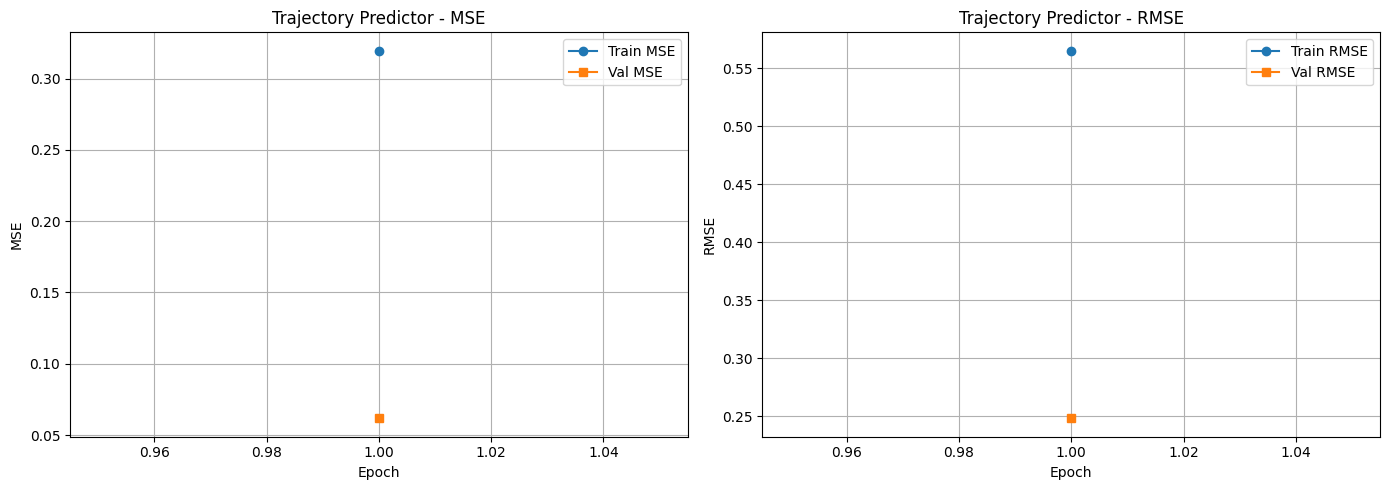


=== FINAL SUMMARY (cluster 1) ===
Best epoch       : 1
Best Val MSE     : 0.061685
Best Val RMSE    : 0.248365
Train MSE @ best : 0.319491
Train RMSE @ best: 0.565235


In [89]:
import matplotlib.pyplot as plt

total_epochs = range(1, len(train_mses) + 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# MSE plot
ax1.plot(total_epochs, train_mses, label="Train MSE", marker="o")
ax1.plot(total_epochs, val_mses,   label="Val MSE",   marker="s")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("MSE")
ax1.set_title("Trajectory Predictor - MSE")
ax1.legend()
ax1.grid(True)

# RMSE plot
ax2.plot(total_epochs, train_rmses, label="Train RMSE", marker="o")
ax2.plot(total_epochs, val_rmses,   label="Val RMSE",   marker="s")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("RMSE")
ax2.set_title("Trajectory Predictor - RMSE")
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

print("\n=== FINAL SUMMARY (cluster 1) ===")
print(f"Best epoch       : {best_epoch}")
print(f"Best Val MSE     : {best_val_mse:.6f}")
print(f"Best Val RMSE    : {val_rmses[best_epoch-1]:.6f}")
print(f"Train MSE @ best : {train_mses[best_epoch-1]:.6f}")
print(f"Train RMSE @ best: {train_rmses[best_epoch-1]:.6f}")


### Plot one past 30 minutes vs. predicted future 30 minutes / actual future 30 minutes

In [102]:
import numpy as np
import pandas as pd
import plotly.express as px

def plot_example_plotly(model, val_loader, device, example_idx=0, feature_idx=0):
    """
    Plot with Plotly:
      - past 30 minutes
      - true future 30 minutes
      - predicted future 30 minutes

    feature_idx: which feature to plot over time (0 = UTM_x, 1 = UTM_y, etc.)
    """
    model.eval()
    xb, yb = next(iter(val_loader))   # xb: (B, T_in, D), yb: (B, T_out, D)
    xb = xb.to(device)
    yb = yb.to(device)

    with torch.no_grad():
        yb_pred = model(
            xb,
            target_length=yb.size(1),
            targets=None,
            teacher_forcing_ratio=0.0,
        )

    xb_ex = xb[example_idx].detach().cpu().numpy()       # (T_in, D)
    y_true = yb[example_idx].detach().cpu().numpy()      # (T_out, D)
    y_pred = yb_pred[example_idx].detach().cpu().numpy() # (T_out, D)

    T_in = xb_ex.shape[0]
    T_out = y_true.shape[0]

    time_past   = np.arange(T_in)
    time_future = np.arange(T_in, T_in + T_out)

    past_df = pd.DataFrame({
        "time_step": time_past,
        "value": xb_ex[:, feature_idx],
        "segment": "Past (30 min)",
    })
    true_df = pd.DataFrame({
        "time_step": time_future,
        "value": y_true[:, feature_idx],
        "segment": "True future (30 min)",
    })
    pred_df = pd.DataFrame({
        "time_step": time_future,
        "value": y_pred[:, feature_idx],
        "segment": "Predicted future (30 min)",
    })

    df = pd.concat([past_df, true_df, pred_df], ignore_index=True)

    fig = px.line(
        df,
        x="time_step",
        y="value",
        color="segment",
        markers=True,
        title=f"Past + True vs Predicted future (feature {feature_idx})",
        labels={"value": "Normalized value", "time_step": "Time step"},
    )
    fig.update_layout(legend_title_text="")
    fig.show()


In [103]:
plot_example_plotly(model, val_loader, device=device, example_idx=0, feature_idx=0)
plot_example_plotly(model, val_loader, device=device, example_idx=0, feature_idx=1)

## These figures show the normalized trajectories. 
## We need to use the scalar to be able to see the actual values

Would also be cool to plot the actual vs. predicted on a map of denmark with plotly.express